# ****FLUSHING ANALYTICS****


# Installing Dependencies

In [261]:
# %pip install pandas
# %pip install pyproj
# %pip install scikit-learn
# %pip install openpyxl
# %pip install matplotlib
# %pip install seaborn

In [262]:
# %pip install xgboost
# %pip install optuna

# Preparing the Data

## Loading and exploring the datasets

In [263]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from pyproj import Proj, transform

# file_path = '/EllaTesting/Files/Repairs_2018_2023.xlsx'

# print(file_path)

# Creating DataFrames from spreadsheets
all_hydrants_filepath = "Updated_Qry_AllHY.csv"
flushing_history_filepath = "Qry_FlushHistory.csv"

all_hydrants_df = pd.read_csv(all_hydrants_filepath)
flushing_history_df = pd.read_csv(flushing_history_filepath)

C:\Users\26154\AppData\Local\Temp\1\ipykernel_25944\3096977762.py:20: DtypeWarning: Columns (4,5,8,10,11,13,14,16,18,20,22,23,24,25,26,28,29,33,35,37,44,46,49,57,68,71,80,89,91,93) have mixed types. Specify dtype option on import or set low_memory=False.
  all_hydrants_df = pd.read_csv(all_hydrants_filepath)
C:\Users\26154\AppData\Local\Temp\1\ipykernel_25944\3096977762.py:21: DtypeWarning: Columns (0,4,5,15,23,24,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  flushing_history_df = pd.read_csv(flushing_history_filepath)


## Data Cleaning and Preprocessing

### Data Cleaning - History Table

In [264]:
# Creating a copy of the Flushing History DataFrame
copied_flushing_history_df = copy.deepcopy(flushing_history_df)

In [265]:
#delete all unnecessary columns
copied_flushing_history_df = copied_flushing_history_df.drop(columns={'FLSHTIME3', 'FLSHTIME4', 'FLSHTIME5', 'FLSHTIME6', 'FLSHTIME7', 'FLSHTIME8', 'FLSHTIME9', 'FLSHTIME10', 'FLSHTIME11', 'FLSHVOL1', 'FLSHVOL2', 'FLSHVOL3', 'FLSHVOL4', 'FLSHVOL5', 'FLSHVOL6', 'FLSHVOL7', 'FLSHVOL8', 'FLSHVOL9', 'FLSHVOL10', 'FLSHVOL11', 'CLFREE3', 
                                                                      'CLFREE4', 'CLFREE5', 'CLFREE6', 'CLFREE7', 'CLFREE8', 'CLFREE9', 'CLFREE10', 'CLFREE11', 'CLTOTL3', 'CLTOTL4', 'CLTOTL5', 'CLTOTL6', 'CLTOTL7', 'CLTOTL8', 'CLTOTL9', 'CLTOTL10', 'CLTOTL11', 'ADDBY', 'ADDDTTM', 'MODBY', 'MODDTTM', 'REMARKS', 'FLSHTIME', 'FLUSHNC', 'NFREASON',  
                                                                      'CLTOTL1', 'CLTOTL2', 'CLTOTL', 'UNSCEHDLD',  'ALTERNATE'})

#### Inspecting the data

In [266]:
copied_flushing_history_df.shape

(116808, 16)

In [267]:
copied_flushing_history_df = copied_flushing_history_df.dropna(subset=['FLSHFRE', 'FLSHDATE', 'CLFREE', 'PHREAD', 'FLSHVOL', 'FLSHDUR', 'COMPKEY'])

In [268]:
copied_flushing_history_df.shape

(112606, 16)

In [269]:
copied_flushing_history_df.head(10)

,INSPKEY,GRIDKEY,FLSHFRE,FLSHDATE,CLFREE,PHREAD,FLSHVOL,FLSHDUR,INSPBY,CLFREE1,CLFREE2,WWNUM,COMMUN,COMPKEY,FLSHTIME1,FLSHTIME2
6,965966,19046430,1 WEEK,2019-04-23,1.18,7.92,1.000,5.0,61535,NaN,NaN,WW220003993,CD,805425.0,NaN,NaN
7,972209,19048814,1 MONTH,2019-04-25,1.66,7.90,18.000,10.0,65673,1.67,NaN,WW220003993,CV,9876.0,15:05,NaN
8,972253,19048815,1 MONTH,2019-04-25,1.33,7.51,10.000,10.0,65673,1.30,NaN,WW260002590,CR,540642.0,09:55,NaN
9,965951,19048816,1 WEEK,2019-04-29,1.69,7.50,6.000,5.0,65673,NaN,NaN,WW260002590,CT,531455.0,NaN,NaN
10,965955,19048817,2 WEEKS,2019-04-30,1.67,7.86,10.000,10.0,65673,1.64,NaN,WW220003993,CV,541072.0,10:50,NaN
11,965950,19048818,1 WEEK,2019-04-30,0.72,8.09,23.000,15.0,65673,0.77,0.82,WW260094120,CB,528297.0,09:40,09:45
12,970581,19048819,2 WEEKS,2019-05-01,1.09,8.21,1.000,5.0,61535,NaN,NaN,WW260094120,CB,9986.0,NaN,NaN
13,970575,19048820,2 WEEKS,2019-05-01,1.11,8.31,1.000,5.0,61535,NaN,NaN,WW260094120,CCC,9263.0,NaN,NaN
14,965730,19048821,3 DAYS,2019-03-01,0.92,7.69,1.194,20.0,35832,NaN,NaN,WW260094120,B,7781.0,NaN,NaN
15,965730,19048822,3 DAYS,2019-04-30,0.42,7.89,5.000,13.0,68527,0.71,NaN,WW260094120,B,7781.0,07:40,NaN


In [270]:
# Calculating the FLSHDATE delta
copied_flushing_history_df = copied_flushing_history_df.sort_values(by=['COMPKEY', 'FLSHDATE'])

copied_flushing_history_df['FLSHDATE'] = pd.to_datetime(copied_flushing_history_df['FLSHDATE'])

copied_flushing_history_df['FLSHDATE_DELTA'] = copied_flushing_history_df.groupby('COMPKEY')['FLSHDATE'].shift(1)  # shift CLFREEFINAL up by 1 row within each COMPKEY group

copied_flushing_history_df['FLSHDATE_DELTA'] = copied_flushing_history_df['FLSHDATE'] - copied_flushing_history_df['FLSHDATE_DELTA']  # calculate the difference between CLFREE and shifted CLFREEFINAL

# copied_flushing_history_df.loc[copied_flushing_history_df['CLDELTA'].isnull(), 'CLDELTA'] = copied_flushing_history_df['CLFREEFINAL']  # fill NaN values with CLFREEFINAL (for the first row of each COMPKEY group)

In [271]:
# Summer months: April-Sept
# Winter months: Oct-March
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['FLSHDATE'].dt.month
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['SEASON'].replace(to_replace=[4, 5, 6, 7, 8, 9],
           value=1)
copied_flushing_history_df['SEASON'] = copied_flushing_history_df['SEASON'].replace(to_replace=[10, 11, 12, 1, 2, 3],
           value=0)
copied_flushing_history_df['SEASON']

15528     0
21057     0
36450     0
62794     0
85374     0
         ..
116406    0
115860    0
115140    0
115821    0
115009    0
Name: SEASON, Length: 112606, dtype: int32

In [272]:
copied_flushing_history_df['CLFREE2'] = copied_flushing_history_df['CLFREE2'].fillna(0)

In [273]:
copied_flushing_history_df['CLFREEFINAL'] = np.where(copied_flushing_history_df['CLFREE2'] > 0, copied_flushing_history_df['CLFREE2'], copied_flushing_history_df['CLFREE1'])

In [274]:
copied_flushing_history_df = copied_flushing_history_df.dropna(subset=['CLFREEFINAL'])
copied_flushing_history_df

,INSPKEY,GRIDKEY,FLSHFRE,FLSHDATE,CLFREE,PHREAD,FLSHVOL,FLSHDUR,INSPBY,CLFREE1,CLFREE2,WWNUM,COMMUN,COMPKEY,FLSHTIME1,FLSHTIME2,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,750335,1826244,1 YEAR,2015-11-30,0.67,0.00,4.00,8.0,68297.0,0.81,0.0,WW260094120,B,1002.0,NaN,NaN,NaT,0,0.81
21057,820873,18494168,1 YEAR,2016-11-24,0.70,0.00,10.00,20.0,68532,0.93,0.0,WW260094120,B,1002.0,NaN,NaN,360 days,0,0.93
62794,1017213,19280486,1 YEAR,2019-12-04,0.91,8.10,2.00,14.0,68527,1.10,0.0,WW260094120,B,1002.0,13:32,NaN,734 days,0,1.10
85374,1125503,19410183,1 YEAR,2021-11-24,0.87,8.02,12.00,15.0,15591,1.23,0.0,WW260094120,B,1002.0,10:30,NaN,721 days,0,1.23
98795,1178642,19463429,1 YEAR,2022-11-24,0.92,8.06,7.14,10.0,68739,0.96,0.0,WW260094120,B,1002.0,08:56,NaN,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116406,1253375,19515396,1 WEEK,2024-05-14,1.15,7.64,15.00,15.0,69695,1.24,0.0,WW220003993,C,1307858.0,12:50,NaN,7 days,0,1.24
115860,1253375,19515992,1 WEEK,2024-05-23,1.12,7.49,17.00,10.0,22506,1.29,0.0,WW220003993,C,1307858.0,12:49,NaN,9 days,0,1.29
115140,1253375,19517454,1 WEEK,2024-05-30,1.00,7.68,20.00,20.0,69695,1.16,0.0,WW220003993,C,1307858.0,09:00,NaN,7 days,0,1.16
115821,1253375,19517764,1 WEEK,2024-06-14,0.69,7.71,12.00,15.0,24289,0.99,0.0,WW220003993,C,1307858.0,14:00,NaN,15 days,0,0.99


In [275]:
copied_flushing_history_df = copied_flushing_history_df.drop(columns=['CLFREE1', 'CLFREE2', 'FLSHTIME1', 'FLSHTIME2', 'INSPKEY', 'GRIDKEY', 'FLSHVOL', 'FLSHDUR', 'INSPBY', 'COMMUN'])

In [276]:
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [277]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['PHREAD'] > 2000].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [278]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['PHREAD'] < 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [279]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['CLFREE'] == 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [280]:
copied_flushing_history_df = copied_flushing_history_df.drop(copied_flushing_history_df[copied_flushing_history_df['CLFREEFINAL'] == 0].index)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [281]:
copied_flushing_history_df['CLFREE'] = copied_flushing_history_df['CLFREE'].replace(78, 0.78)
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96
...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99


In [282]:
# Calculates a new column representing the difference between the CLFREE reading before a flush and the CLFREEFINAL reading of the previous flush (the first flush for a given hydrant is given the value equal to the CLFREEFINAL reading of the flush)
copied_flushing_history_df = copied_flushing_history_df.sort_values(by=['COMPKEY', 'FLSHDATE'])

copied_flushing_history_df['CLDELTA'] = copied_flushing_history_df.groupby('COMPKEY')['CLFREEFINAL'].shift(1)  # shift CLFREEFINAL up by 1 row within each COMPKEY group

copied_flushing_history_df['CLDELTA'] = copied_flushing_history_df['CLFREE'] - copied_flushing_history_df['CLDELTA']  # calculate the difference between CLFREE and shifted CLFREEFINAL

copied_flushing_history_df.loc[copied_flushing_history_df['CLDELTA'].isnull(), 'CLDELTA'] = copied_flushing_history_df['CLFREEFINAL']  # fill NaN values with CLFREEFINAL (for the first row of each COMPKEY group)

In [283]:
wwnum_temp = pd.get_dummies(copied_flushing_history_df['WWNUM'])
copied_flushing_history_df = copied_flushing_history_df.join(wwnum_temp)

In [284]:
copied_flushing_history_df

,FLSHFRE,FLSHDATE,CLFREE,PHREAD,WWNUM,COMPKEY,FLSHDATE_DELTA,SEASON,CLFREEFINAL,CLDELTA,WW220003993,WW220004000,WW220004037,WW260002590,WW260094120
15528,1 YEAR,2015-11-30,0.67,0.00,WW260094120,1002.0,NaT,0,0.81,0.81,False,False,False,False,True
21057,1 YEAR,2016-11-24,0.70,0.00,WW260094120,1002.0,360 days,0,0.93,-0.11,False,False,False,False,True
62794,1 YEAR,2019-12-04,0.91,8.10,WW260094120,1002.0,734 days,0,1.10,-0.02,False,False,False,False,True
85374,1 YEAR,2021-11-24,0.87,8.02,WW260094120,1002.0,721 days,0,1.23,-0.23,False,False,False,False,True
98795,1 YEAR,2022-11-24,0.92,8.06,WW260094120,1002.0,365 days,0,0.96,-0.31,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116406,1 WEEK,2024-05-14,1.15,7.64,WW220003993,1307858.0,7 days,0,1.24,-0.30,True,False,False,False,False
115860,1 WEEK,2024-05-23,1.12,7.49,WW220003993,1307858.0,9 days,0,1.29,-0.12,True,False,False,False,False
115140,1 WEEK,2024-05-30,1.00,7.68,WW220003993,1307858.0,7 days,0,1.16,-0.29,True,False,False,False,False
115821,1 WEEK,2024-06-14,0.69,7.71,WW220003993,1307858.0,15 days,0,0.99,-0.47,True,False,False,False,False


In [285]:
copied_flushing_history_df = copied_flushing_history_df.drop(columns=['WWNUM', 'FLSHDATE'])

In [286]:
# Encoding True/False values from the get_dummies() function as 1/0
# Replacing True/False values with 1 and 0 respectively
copied_flushing_history_df = copied_flushing_history_df.replace(True, 1)
copied_flushing_history_df = copied_flushing_history_df.replace(False, 0)

C:\Users\26154\AppData\Local\Temp\1\ipykernel_25944\462007816.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_flushing_history_df = copied_flushing_history_df.replace(False, 0)


In [287]:
copied_flushing_history_df.to_excel('historycheck.xlsx', index=False)

**Imputing Missing Categorical Values**

In [288]:
# #TODO: Ayan: Use the COMPKEY to fill out the missing values in COMMUN
# # Sorting the DataFrame by COMPKEY, as there is a pattern between COMPKEY values and COMMUN values
# copied_flushing_history_df = copied_flushing_history_df.sort_values('COMPKEY')

# # Imputing every missing value with the value that came before it in the sorted DataFrame
# copied_flushing_history_df['COMMUN'] = copied_flushing_history_df['COMMUN'].ffill()

**Imputing Missing Numerical Values**

In [289]:
# # Imputing missing values in the FLSHVOL and FLSHDUR columns with the median of the column
# copied_flushing_history_df['FLSHVOL'] = copied_flushing_history_df['FLSHVOL'].fillna(copied_flushing_history_df['FLSHVOL'].median())
# copied_flushing_history_df['FLSHDUR'] = copied_flushing_history_df['FLSHDUR'].fillna(copied_flushing_history_df['FLSHDUR'].median())

**Detecting and Replacing Outliers**

In [290]:
# # For visualizing the box and whisker plot
# import seaborn as sns

# # Replaces all outliers within a given column with the median of that column
# def replace_outliers(df, column):
#     # Creates a box and whisker plot to visualize data points that are considered to be outliers
#     sns.boxplot(df[column])
#     plt.title(f"Original Box and Whisker Plot for {column}")
#     plt.show()
    
#     # Computing the first, second (median), and third quartiles
#     q1 = df[column].quantile(0.25)
#     q2 = df[column].quantile(0.5)
#     q3 = df[column].quantile(0.75)

#     print(f"First quartile is {q1}")
#     print(f"Median is {q2}")
#     print(f"Third quartile is {q3}")
    
#     # Computing the interquartile range
#     iqr = q3 - q1

#     # Values that are lower than the lower fence or higher than the upper fence are considered to be outliers
#     lower_fence = q1 - (1.5 * iqr)
#     upper_fence = q3 + (1.5 * iqr)

#     print(f"Lower fence is {lower_fence}")
#     print(f"Upper fence is {upper_fence}")

#     # Replace outliers with the median
#     adjusted_column = [x if lower_fence <= x <= upper_fence else q2 for x in df[column]]
    
#     # New box and whisker plot with outliers adjusted
#     sns.boxplot(adjusted_column)
#     plt.title(f"New Box and Whisker Plot for {column}")
#     plt.show()

#     return adjusted_column

In [291]:
# Replacing outliers in the FLSHVOL column
# copied_flushing_history_df['FLSHVOL'] = replace_outliers(copied_flushing_history_df, 'FLSHVOL')

In [292]:
# Replacing outliers in the FLSHDUR column
# copied_flushing_history_df['FLSHDUR'] = replace_outliers(copied_flushing_history_df, 'FLSHDUR')

### Data Cleaning - Hydrant Table

In [293]:
# Creating a copy of the All Hydrants DataFrame
copied_all_hydrants_df = copy.deepcopy(all_hydrants_df)

In [294]:
# Filters rows where flushing frequency is blank
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['FLSHFRE'].notnull()]
copied_all_hydrants_df.describe()

,ADDRKEY,IMSRO_COMPHY_COMPKEY,PRCLKEY,SEGKEY,WVKEY,XCOORD,YCOORD,LASTFREE,LASTOTAL,LSTFMAX1,...,EMASSTCRTL,EMASSTCRDT,EMASSTRISK,EMASTRSKDT,EMDISTRICT,EMEQPMNTCL,EMEQPMNTTP,EMASSTDESC,EMCOND,EMCONDDATE
count,2388.000000,2.390000e+03,2390.000000,2388.0,2390.000000,2.390000e+03,2.389000e+03,2328.000000,2329.000000,2327.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,81107.974037,3.360691e+05,1.002092,1.0,508.465820,6.071278e+05,4.833597e+06,1.171462,1.375311,1.371856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,122066.894270,4.165201e+05,0.073738,0.0,17538.989535,1.225211e+05,9.960603e+04,0.216069,0.223664,0.229154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1003.000000,1.000000e+00,1.000000,1.0,1.000000,5.741070e+05,1.687867e+02,0.300000,0.000000,0.430000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3242.500000,9.033250e+03,1.000000,1.0,1.000000,5.998912e+05,4.825940e+06,1.030000,1.230000,1.230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5475.500000,1.939450e+04,1.000000,1.0,1.000000,6.031306e+05,4.833903e+06,1.160000,1.360000,1.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,129041.500000,7.155450e+05,1.000000,1.0,1.000000,6.084413e+05,4.842762e+06,1.310000,1.520000,1.520000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,437401.000000,1.312755e+06,4.000000,1.0,609252.930000,4.840275e+06,4.869890e+06,1.880000,2.190000,2.190000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['OWN'].isin(['R', 'NAMP'])]
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['SERVSTAT'].isin(['A', 'ANYR'])]
copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['EXPDATE'].isnull()]

In [296]:
# Dropping unnecessary columns
copied_all_hydrants_df = copied_all_hydrants_df.drop(columns={'ADDRKEY', 'ADDRQUAL', 'AUXVALVE', 'BARRELSIZE', 'COMPLEXKEY', 'GISSTATIC', 'HT', 'INTKEY', 'MAPNO', 'OBST', 'OUTLSZ4', 'PACKING', 'PAINTTYPE', 'PRCLKEY', 'SEGKEY', 'SERNO', 'SLKEY', 'SPECINST', 'STKEY', 'WVKEY', 'BGTNO', 'USGAREAKEY', 'EXPBY', 'EXPDATE', 'ADDBY', 'MODBY', 'MODDTTM',
                                                              'LASTINSP', 'LASTWINT', 'OLDID', 'WMODID', 'MUNICIPAL', 'FLUDATE', 'WWNUM', 'LASTFREE', 'LASTOTAL', 'FLSHFRE_GIS', 'MINFLTM', 'AVKCLIP', 'ASUMDATE', 'MAINTBY', 'REPLABY', 'REPLAFOR', 'FRFLWVLDDT', 'ASSTGRPID', 'EMDEPT', 'EMDIV', 'EMSERV', 'EMSERVCAT', 'EMCAMASTCL', 'EMASSTPRNT', 'EMPURCHDAT',
                                                                  'EMESTSRVLF', 'EMRMGSRVLF', 'EMRMSRLFDT', 'EMREPLCOST', 'EMREPCOSDT', 'EMPURINCST', 'EMASSTCRTL', 'EMASSTCRDT', 'EMASSTRISK', 'EMASTRSKDT', 'EMDISTRICT', 'EMEQPMNTCL', 'EMEQPMNTTP', 'EMASSTDESC', 'EMCOND', 'EMCONDDATE', 'OWN', 'SERVSTAT', 'DISTRICT', 'ASBLT', 'WATPLATT',
                                                                  'LSTFMAX1',	'LSTFMAX2',	'LSTFMAX3',	'AVE3FMAX',	'LSTTMAX1',	'LSTTMAX2',	'LSTTMAX3',	'AVE3TMAX', 'ASBLT', 'ZCOORD', 'PRESSMIN',	'PRESSMAX',	'FIRFLGPM',	'OUTELEVN',	'MDLRESRD', 'FEEDERTYPE'})

In [297]:
# Filtering out invalid values
# copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['OWN'].isin(['R', 'NAMP'])]
# copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['SERVSTAT'].isin(['A', 'ANYR'])]
# copied_all_hydrants_df = copied_all_hydrants_df[copied_all_hydrants_df['EXPDATE'].isnull()]

**Imputing Missing Categorical Values**

In [298]:
# Item 3: Clean data, replace nulls with values in some columns
copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].fillna(0)

In [299]:
copied_all_hydrants_df['UNITTYPE'].describe()

count       2210
unique         2
top       HYBLWF
freq        2172
Name: UNITTYPE, dtype: object

In [300]:
#TODO: Ayan: Imputing the missing data for PRESZONE
# Based on other rows with similar data as the missing rows in PRESZONE, PG8 is the most suitable value to impute here
copied_all_hydrants_df['PRESZONE'] = copied_all_hydrants_df['PRESZONE'].fillna("PG8")

In [301]:
#TODO: Ayan: Imputation for DECLREQD
# Replacing blank values in the 'DECLREQD' column with the mode of the column
copied_all_hydrants_df['DECLREQD'] = copied_all_hydrants_df['DECLREQD'].fillna(copied_all_hydrants_df['DECLREQD'].mode().iloc[0])

In [302]:
#TODO: Ella: Convert null to N for HYMARKER
copied_all_hydrants_df['HYMARKER'] = copied_all_hydrants_df['HYMARKER'].fillna('N')

In [303]:
#TODO: Ayan: Impute the missing value for NONSCHE
copied_all_hydrants_df['NONSCHE'] = copied_all_hydrants_df['NONSCHE'].fillna(copied_all_hydrants_df['NONSCHE'].mode().iloc[0])

In [304]:
copied_all_hydrants_df.head()

,AREA,COLOR,IMSRO_COMPHY_COMPKEY,FEEDERDIAM,FEEDERLEN,INSTDATE,LOC,MAINKEY,MFGKEY,MODELNO,...,ADDDTTM,FLSHFRE,LONGKEY,PLUGGED,COMMUN,NONSCHE,FZONENUM,DECLREQD,WARDID,HYMARKER
65,B31,BLUE,1673.0,0.0,1.4,2008-10-16 08:21:00,1031,526297,1012,CENTURY,...,2003-03-01,1 YEAR,N,N,B,N,FZ-C01,N,B02,Y
76,B31,BLUE,1696.0,0.0,1.1,2007-01-11 08:44:00,1145,754390,1022,M67,...,2003-03-01,1 YEAR,N,N,B,N,FZ-C01,Y,B02,N
126,B31,BLUE,2847.0,0.0,1.1,2008-08-29 11:00:00,1058,762853,1012,CENTURY,...,2003-03-01,1 YEAR,N,N,B,N,FZ-C01,N,B02,N
138,B06,ORANGE,2863.0,0.0,3.0,2008-06-12 14:14:00,0641,512055,1009,D67M,...,2003-03-01,1 YEAR,N,N,B,N,FZ-C03,N,B04,N
139,B12,BLUE,2864.0,0.0,1.0,2008-06-13 17:29:00,0821,716655,1022,M59M,...,2003-03-01,1 YEAR,N,N,B,N,FZ-C03,Y,B07,N


**Binning**

In [305]:
#TODO: Jordan: Imputing the missing data for SUBAREA
#TODO: Jordan: What are the differences between AREA, SUBAREA, COMMUN, WARDID. Which columns to keep and why?

subarea_mode = copied_all_hydrants_df['SUBAREA'].mode()[0]
copied_all_hydrants_df['SUBAREA'] = copied_all_hydrants_df['SUBAREA'].fillna(subarea_mode)
print(copied_all_hydrants_df['SUBAREA'].isna().sum())

# Extracting only the letters from the AREA column
copied_all_hydrants_df['Letters'] = copied_all_hydrants_df['AREA'].str.extract(r'([A-Za-z]+)', expand=False)

# Displaying the resulting DataFrame with only the letters
print(copied_all_hydrants_df[['AREA', 'Letters']])

0
      AREA Letters
65     B31       B
76     B31       B
126    B31       B
138    B06       B
139    B12       B
...    ...     ...
40349  C36       C
40515  B34       B
40516  B34       B
40517  B34       B
40556  B34       B

[2210 rows x 2 columns]


In [306]:
copied_all_hydrants_df[copied_all_hydrants_df['Letters'].isnull()]

,AREA,COLOR,IMSRO_COMPHY_COMPKEY,FEEDERDIAM,FEEDERLEN,INSTDATE,LOC,MAINKEY,MFGKEY,MODELNO,...,FLSHFRE,LONGKEY,PLUGGED,COMMUN,NONSCHE,FZONENUM,DECLREQD,WARDID,HYMARKER,Letters
35896,NaN,BLUE,943278.0,150.0,2.0,2015-03-21,0168,518558,1012,CENTURY,...,3 DAYS,N,N,M,N,FZ-W01,Y,M08,Y,NaN


In [307]:
# Imputing the missing value with the most suitable value based on 
copied_all_hydrants_df['Letters'] = copied_all_hydrants_df['Letters'].fillna("S")

In [308]:
# One hot encoding the given columns
copied_all_hydrants_df = pd.get_dummies(data=copied_all_hydrants_df, columns=['COLOR', 'MFGKEY', 'PRESZONE', 'Letters', 'FZONENUM'])

In [309]:
# Displaying the resulting DataFrame to ensure the columns are included
print("Original DataFrame with extracted letters and one-hot encoded columns:")
print(copied_all_hydrants_df.head())

Original DataFrame with extracted letters and one-hot encoded columns:
    AREA  IMSRO_COMPHY_COMPKEY FEEDERDIAM FEEDERLEN             INSTDATE  \
65   B31                1673.0        0.0       1.4  2008-10-16 08:21:00   
76   B31                1696.0        0.0       1.1  2007-01-11 08:44:00   
126  B31                2847.0        0.0       1.1  2008-08-29 11:00:00   
138  B06                2863.0        0.0       3.0  2008-06-12 14:14:00   
139  B12                2864.0        0.0       1.0  2008-06-13 17:29:00   

      LOC MAINKEY  MODELNO OUTLSZ1 OUTLSZ2  ... FZONENUM_FZ-C03  \
65   1031  526297  CENTURY      63     150  ...           False   
76   1145  754390      M67      63     150  ...           False   
126  1058  762853  CENTURY      63      63  ...           False   
138  0641  512055     D67M      63     150  ...            True   
139  0821  716655     M59M      63      63  ...            True   

    FZONENUM_FZ-V01 FZONENUM_FZ-V02 FZONENUM_FZ-V03  FZONENUM_FZ-V04 

**Label Encoding**

In [310]:
# Encoding UNITTYPE as 1 or 0
copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("HYBLWF", 1)
# copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("STDHY", 0)
copied_all_hydrants_df['UNITTYPE']

C:\Users\26154\AppData\Local\Temp\1\ipykernel_25944\3827388087.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_all_hydrants_df['UNITTYPE'] = copied_all_hydrants_df['UNITTYPE'].replace("HYBLWF", 1)


65       1
76       1
126      1
138      1
139      1
        ..
40349    1
40515    1
40516    1
40517    1
40556    1
Name: UNITTYPE, Length: 2210, dtype: int64

In [311]:
# Replacing True/False values with 1 and 0 respectively
copied_all_hydrants_df = copied_all_hydrants_df.replace(True, 1)
copied_all_hydrants_df = copied_all_hydrants_df.replace(False, 0)

C:\Users\26154\AppData\Local\Temp\1\ipykernel_25944\3996280979.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  copied_all_hydrants_df = copied_all_hydrants_df.replace(False, 0)


In [312]:
copied_all_hydrants_df

,AREA,IMSRO_COMPHY_COMPKEY,FEEDERDIAM,FEEDERLEN,INSTDATE,LOC,MAINKEY,MODELNO,OUTLSZ1,OUTLSZ2,...,FZONENUM_FZ-C03,FZONENUM_FZ-V01,FZONENUM_FZ-V02,FZONENUM_FZ-V03,FZONENUM_FZ-V04,FZONENUM_FZ-V05,FZONENUM_FZ-W01,FZONENUM_FZ-W02,FZONENUM_FZ-W03,FZONENUM_FZ-W04
65,B31,1673.0,0,1.4,2008-10-16 08:21:00,1031,526297,CENTURY,63,150,...,0,0,0,0,0,0,0,0,0,0
76,B31,1696.0,0,1.1,2007-01-11 08:44:00,1145,754390,M67,63,150,...,0,0,0,0,0,0,0,0,0,0
126,B31,2847.0,0,1.1,2008-08-29 11:00:00,1058,762853,CENTURY,63,63,...,0,0,0,0,0,0,0,0,0,0
138,B06,2863.0,0,3.0,2008-06-12 14:14:00,0641,512055,D67M,63,150,...,1,0,0,0,0,0,0,0,0,0
139,B12,2864.0,0,1,2008-06-13 17:29:00,0821,716655,M59M,63,63,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40349,C36,1307858.0,150.0,446.888,2024-04-04 23:59:00,1821,1279565,NaN,0,0,...,0,0,0,1,0,0,0,0,0,0
40515,B34,1285373.0,150.0,2.291,2024-06-25 18:00:00,0913,1285191,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
40516,B34,1312734.0,150.0,3.224,2024-06-25 18:00:00,0941,1285151,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
40517,B34,1312743.0,150.0,3.366,2024-06-25 18:00:00,0942,1285106,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0


In [313]:
# Encoding Y as 1 and N as 0 for the given columns
copied_all_hydrants_df[['LONGKEY', 'PLUGGED', 'NONSCHE', 'DECLREQD', 'HYMARKER']] = (copied_all_hydrants_df[['LONGKEY', 'PLUGGED', 'NONSCHE', 'DECLREQD', 'HYMARKER']] == 'TRUE').astype(int)

In [314]:
# from sklearn.preprocessing import OneHotEncoder

# # One-hot encoding 'COLOR', 'MFGKEY', 'PRESZONE', 'Letters', 'FZONENUM'
# encoder = OneHotEncoder(sparse_output=False)
# encoded_letters = encoder.fit_transform(copied_all_hydrants_df[['Letters']])
# encoded_letters_df = pd.DataFrame(encoded_letters, columns=encoder.get_feature_names_out(['Letters']))

# # Combining the original DataFrame with the encoded letters
# copied_all_hydrants_df = pd.concat([copied_all_hydrants_df, encoded_letters_df], axis=1)

# # Displaying the resulting DataFrame to ensure the columns are included
# print("Original DataFrame with extracted letters and one-hot encoded columns:")
# print(copied_all_hydrants_df.head())

In [315]:
#TODO: Jordan: Clean up the values in MODEL column (group those that are of similar values but in different forms) & fill the null value with UNKNOWN - Done
#TODO: ELla to clean up the grouping

# # Standardize the values in the MODELNO column
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].str.strip().str.upper()

# # Fill missing values with 'UNKNOWN'
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].fillna('UNKNOWN')

In [316]:
# # Define a mapping for similar model numbers
# modelno_mapping = {
#     'BRIGADIER': [
#         'BRIG', 'BRIGADIER', 'BRIGADIER M67', 'BRIGADEER', 'BRIGADERE', 
#         'BRIGD', 'BRIGA', 'BRIGADIER M64', 'BRIGADIER M67B', 
#         'BRIGADIER M67B-002', 'BRIGIDAR', 'BRIGIDERE', 'BRIGG', 'BRIG.', 'brig', 'brig.', 'Brig'
#     ],
#     'CENTURY': [
#         'CENTURY', 'century', 'CEN', 'CENT', 'CENTRY', 'CENTRUY', 
#         'CENURY', 'CENTY', 'CENTRYY', 'CENRTY', 'CCENTURY', 'c entury', 'CEN.'
#     ],
#     '27/100': ['27/100', '27-100', '27-00', '27/00', 'B52700'],
#     'M67': [
#         'M67', 'M67B', 'M67B-002', 'M67-B', 'M67 BRIG', 'M67 BRIGADIER', 
#         'M67 BRIGADIER', 'M67-BRIG', 'M67D', 'M67E', 'M67Y', 'M67m', 
#         'M67\r\nM67', 'M-67', 'M67M', 'M 67', 'M67-brig.', 'm67', 'm67b'
#     ],
#     'D67': ['D67', 'D67M', 'D-67', 'D-67M', 'D67m', 'D57M'],
#     'B50': [
#         'B50', 'B50-B24', 'B50-B18', 'B50-B-24', 'B-50-B', 
#         'B-50', 'B67', 'B560-B24', 'B50B'
#     ],
#     'C': ['C', 'C61', 'C61A'],
#     '3 PORT': [
#         '#5', '5', '3', '3-PORT', '3 PORT', '3 PORTS', '3PORT BRIGADIER', 
#         '3PORT BRIGADIER M67B', '3PORT BRIGADIER M67B', 'M3', 
#         'M-93', 'SIGELOCK SPARTAN', 'THREE PORT', 'TWO PORT'
#     ]
#     # Add more mappings as needed
# }

In [317]:
# # Reverse the mapping for easy replacement
# reverse_modelno_mapping = {}
# for key, values in modelno_mapping.items():
#     for value in values:
#         reverse_modelno_mapping[value] = key

# # Apply the mapping to the MODELNO column
# copied_all_hydrants_df['MODELNO'] = copied_all_hydrants_df['MODELNO'].replace(reverse_modelno_mapping)

In [318]:
# # Verify the changes
# print(copied_all_hydrants_df['MODELNO'].unique())
# print(copied_all_hydrants_df['MODELNO'].isna().sum())

# # Save the cleaned dataset
# copied_all_hydrants_df.to_excel('cleaned_hydrantcheck.xlsx', index=False)

In [319]:
# Bin and then one hot encode the MODELNO column? ***?
# AVK: 27/100, 27 100, 
# MUELLER: 3 PORT, B-05, B20-24, B50, C, CAN-VAL, CENTURY, DARLING,
# CLOW: D67, D-67M, BRIGADIER, M59, M67, MCAVITY, MACAVITY, MUELLER, SENTINEL

**Extracting Dates**

In [320]:
copied_all_hydrants_df['INSTDATE'] = copied_all_hydrants_df['INSTDATE'].replace('9999-01-01', '2016-03-24')

In [321]:
# Converting date column to datetime
copied_all_hydrants_df['INSTDATE'] = pd.to_datetime(copied_all_hydrants_df['INSTDATE'], format='ISO8601')

# Displaying the resulting DataFrame
print(copied_all_hydrants_df['INSTDATE'].head())

65    2008-10-16 08:21:00
76    2007-01-11 08:44:00
126   2008-08-29 11:00:00
138   2008-06-12 14:14:00
139   2008-06-13 17:29:00
Name: INSTDATE, dtype: datetime64[ns]


In [322]:
# Ensuring that there aren't any blanks being created in INSTDATE
copied_all_hydrants_df['INSTDATE'].isna().unique()

array([False])

In [323]:
# Calculate the age in days
copied_all_hydrants_df['AGE'] = (pd.Timestamp.now() - copied_all_hydrants_df['INSTDATE']).dt.days

# If INSTDATE was missing, AGE will be NaN
copied_all_hydrants_df['AGE'] = copied_all_hydrants_df['AGE'].fillna(-1)  # Filling with -1 to indicate missing ages, you can choose other strategies

print(copied_all_hydrants_df[['INSTDATE', 'AGE']].head(100))

                INSTDATE    AGE
65   2008-10-16 08:21:00   5790
76   2007-01-11 08:44:00   6434
126  2008-08-29 11:00:00   5837
138  2008-06-12 14:14:00   5915
139  2008-06-13 17:29:00   5914
...                  ...    ...
1892 2001-11-12 15:34:00   8319
1898 1995-12-11 00:00:00  10483
1923 2008-10-17 15:49:00   5788
1936 2008-10-21 07:31:00   5785
1943 2008-08-29 10:10:00   5838

[100 rows x 2 columns]


In [324]:
# Maps a value from FLSHFRE to an integer representing the frequency in days
def convert_to_days(frequency):
    if pd.isna(frequency):
        return None
    frequency = frequency.upper().strip()
    if 'DAY' in frequency:
        return int(frequency.split()[0])
    elif 'DAILY' in frequency:
        return 1
    elif 'WEEK' in frequency:
        return int(frequency.split()[0]) * 7
    elif 'MONTH' in frequency:
        return int(frequency.split()[0]) * 30
    elif 'YEAR' in frequency:
        return int(frequency.split()[0]) * 365
    else:
        return None  # For any unknown frequency format

In [325]:
# Apply the conversion function
copied_all_hydrants_df['FLSHFRE_DAYS'] = copied_all_hydrants_df['FLSHFRE'].apply(convert_to_days)
print(copied_all_hydrants_df[['FLSHFRE', 'FLSHFRE_DAYS']].head())

print(copied_all_hydrants_df['FLSHFRE_DAYS'].unique())
print(copied_all_hydrants_df['FLSHFRE'].unique())

    FLSHFRE  FLSHFRE_DAYS
65   1 YEAR           365
76   1 YEAR           365
126  1 YEAR           365
138  1 YEAR           365
139  1 YEAR           365
[365  90 180   3   7 120  14  30  60  21   2   1]
['1 YEAR' '3 MONTHS' '6 MONTHS' '3 DAYS' '1 WEEK' '4 MONTHS' '2 WEEKS'
 '1 MONTH' '2 MONTHS' '3 WEEKS' '2 DAYS' 'DAILY']


In [326]:
copied_all_hydrants_df = copied_all_hydrants_df.drop(columns=['AREA', 'LOC', 'MAINKEY', 'SUBAREA', 'UNITID', 'XCOORD', 'YCOORD', 'ADDDTTM', 'IMSRO_VARHY_COMPKEY', 'FLSHFRE', 'LONGKEY', 'PLUGGED', 'COMMUN', 'NONSCHE', 'DECLREQD', 'WARDID', 'HYMARKER'])

In [327]:
copied_all_hydrants_df.to_csv('hydrantcheck.csv', index=False)

### Merging the datasets

In [328]:
#TODO: Ayan to find the right column to merge the 2 datasets. After merging, delete all the ...KEY columns (identification columns) in the merge df
# Renaming the column so that the name is the same in both datasets
copied_all_hydrants_df.rename(columns={'IMSRO_COMPHY_COMPKEY': 'COMPKEY'}, inplace=True)

In [329]:
# Merging the DataFrames based on the 'COMPKEY' column - similar to a SQL left outer join
merged_df = pd.merge(copied_all_hydrants_df, copied_flushing_history_df, on='COMPKEY', how='right', indicator=True)

# Removing the COMPKEY column now that we don't need it
merged_df.drop(['COMPKEY'], axis=1, inplace=True)

In [330]:
merged_df['FLSHFRE'].unique()

array(['1 YEAR', '6 MONTHS', '3 MONTHS', '4 MONTHS', '2 MONTHS', '2 DAYS',
       '3 DAYS', '1 WEEK', '1 MONTH', '2 WEEKS', '6 WEEKS', 'DAYS',
       '3 WEEKS', 'DAILY', '2 X DAILY', '1 week', '2 days', '2DAYS'],
      dtype=object)

In [331]:
# Adjusting incorrectly formatted rows
merged_df['FLSHFRE'] = merged_df['FLSHFRE'].replace(['DAYS', '2DAYS'], '2 DAYS')

In [332]:
merged_df['FLSHFRE'].unique()

array(['1 YEAR', '6 MONTHS', '3 MONTHS', '4 MONTHS', '2 MONTHS', '2 DAYS',
       '3 DAYS', '1 WEEK', '1 MONTH', '2 WEEKS', '6 WEEKS', '3 WEEKS',
       'DAILY', '2 X DAILY', '1 week', '2 days'], dtype=object)

In [333]:
# Using the FLSHFRE values from the Flushing History dataset to get the frequency in days
merged_df['FLSHFRE_DAYS'] = merged_df['FLSHFRE'].apply(convert_to_days)

In [334]:
# Removing features we don't need
merged_df = merged_df.drop(['FLSHFRE', 'MODELNO', 'INSTDATE'], axis=1)

In [335]:
merged_df = merged_df.drop(['FLSHDATE_DELTA','CLFREE','CLFREEFINAL'], axis=1)

In [336]:
# Save the result to a new Excel file
# merged_df.to_excel('merged_dataset.xlsx', index=False)
merged_df.to_csv('merged_dataset.csv',index=False)

In [337]:
# Only taking rows with complete data (i.e. rows that merged on both datasets)
merged_df = merged_df.loc[merged_df['_merge'] == "both"]
# Removing the merge column, as we won't need it as a feature
merged_df = merged_df.drop(['_merge'], axis=1)
merged_df

,FEEDERDIAM,FEEDERLEN,OUTLSZ1,OUTLSZ2,OUTLSZ3,UNITTYPE,COLOR_BLUE,COLOR_GREEN,COLOR_ORANGE,MFGKEY_1.0,...,AGE,FLSHFRE_DAYS,PHREAD,SEASON,CLDELTA,WW220003993,WW220004000,WW220004037,WW260002590,WW260094120
0,0,2.0,63,150,63,1.0,1.0,0.0,0.0,0.0,...,13902.0,365,0.00,0,0.81,0,0,0,0,1
1,0,2.0,63,150,63,1.0,1.0,0.0,0.0,0.0,...,13902.0,365,0.00,0,-0.11,0,0,0,0,1
2,0,2.0,63,150,63,1.0,1.0,0.0,0.0,0.0,...,13902.0,365,8.10,0,-0.02,0,0,0,0,1
3,0,2.0,63,150,63,1.0,1.0,0.0,0.0,0.0,...,13902.0,365,8.02,0,-0.23,0,0,0,0,1
4,0,2.0,63,150,63,1.0,1.0,0.0,0.0,0.0,...,13902.0,365,8.06,0,-0.31,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99831,150.0,446.888,0,0,0,1.0,0.0,0.0,0.0,0.0,...,140.0,7,7.64,0,-0.30,1,0,0,0,0
99832,150.0,446.888,0,0,0,1.0,0.0,0.0,0.0,0.0,...,140.0,7,7.49,0,-0.12,1,0,0,0,0
99833,150.0,446.888,0,0,0,1.0,0.0,0.0,0.0,0.0,...,140.0,7,7.68,0,-0.29,1,0,0,0,0
99834,150.0,446.888,0,0,0,1.0,0.0,0.0,0.0,0.0,...,140.0,7,7.71,0,-0.47,1,0,0,0,0


In [338]:
# Converting columns into appropriate data types
merged_df[['OUTLSZ1', 'OUTLSZ2', 'OUTLSZ3']] = merged_df[['OUTLSZ1', 'OUTLSZ2', 'OUTLSZ3']].astype(int)
merged_df[['FEEDERDIAM', 'FEEDERLEN']] = merged_df[['FEEDERDIAM', 'FEEDERLEN']].astype(float)

### Feature Selection
Using mutual information

In [339]:
from sklearn.feature_selection import mutual_info_regression

# Separating the dataset by features (independent variables) and target (dependent variable)
x = merged_df.drop('CLDELTA', axis=1)
y = merged_df['CLDELTA']

In [340]:
mi_scores = mutual_info_regression(x, y)

In [343]:
mi_scores

array([2.81906311e-03, 6.44682053e-02, 9.33814876e-04, 8.91010470e-03,
       7.97661948e-03, 0.00000000e+00, 9.55319636e-05, 3.02829471e-03,
       2.28348533e-03, 2.98747264e-03, 0.00000000e+00, 1.82795050e-03,
       2.13327746e-03, 0.00000000e+00, 3.63110815e-03, 1.90902022e-03,
       0.00000000e+00, 2.62041847e-03, 3.08070857e-03, 0.00000000e+00,
       0.00000000e+00, 3.54926836e-03, 5.05942790e-03, 2.28813180e-03,
       1.93287260e-03, 2.86907327e-03, 3.73049053e-03, 7.42782493e-03,
       0.00000000e+00, 2.14756456e-03, 0.00000000e+00, 0.00000000e+00,
       3.13068599e-03, 1.11473384e-03, 0.00000000e+00, 1.92898810e-04,
       9.40183819e-04, 0.00000000e+00, 0.00000000e+00, 7.19437803e-04,
       4.08889166e-03, 5.40655246e-03, 6.18508860e-03, 9.24995771e-05,
       0.00000000e+00, 4.73747436e-03, 6.14165162e-03, 2.68799682e-03,
       6.20046458e-03, 0.00000000e+00, 1.29696585e-03, 1.71118240e-03,
       0.00000000e+00, 5.58682599e-03, 0.00000000e+00, 0.00000000e+00,
      

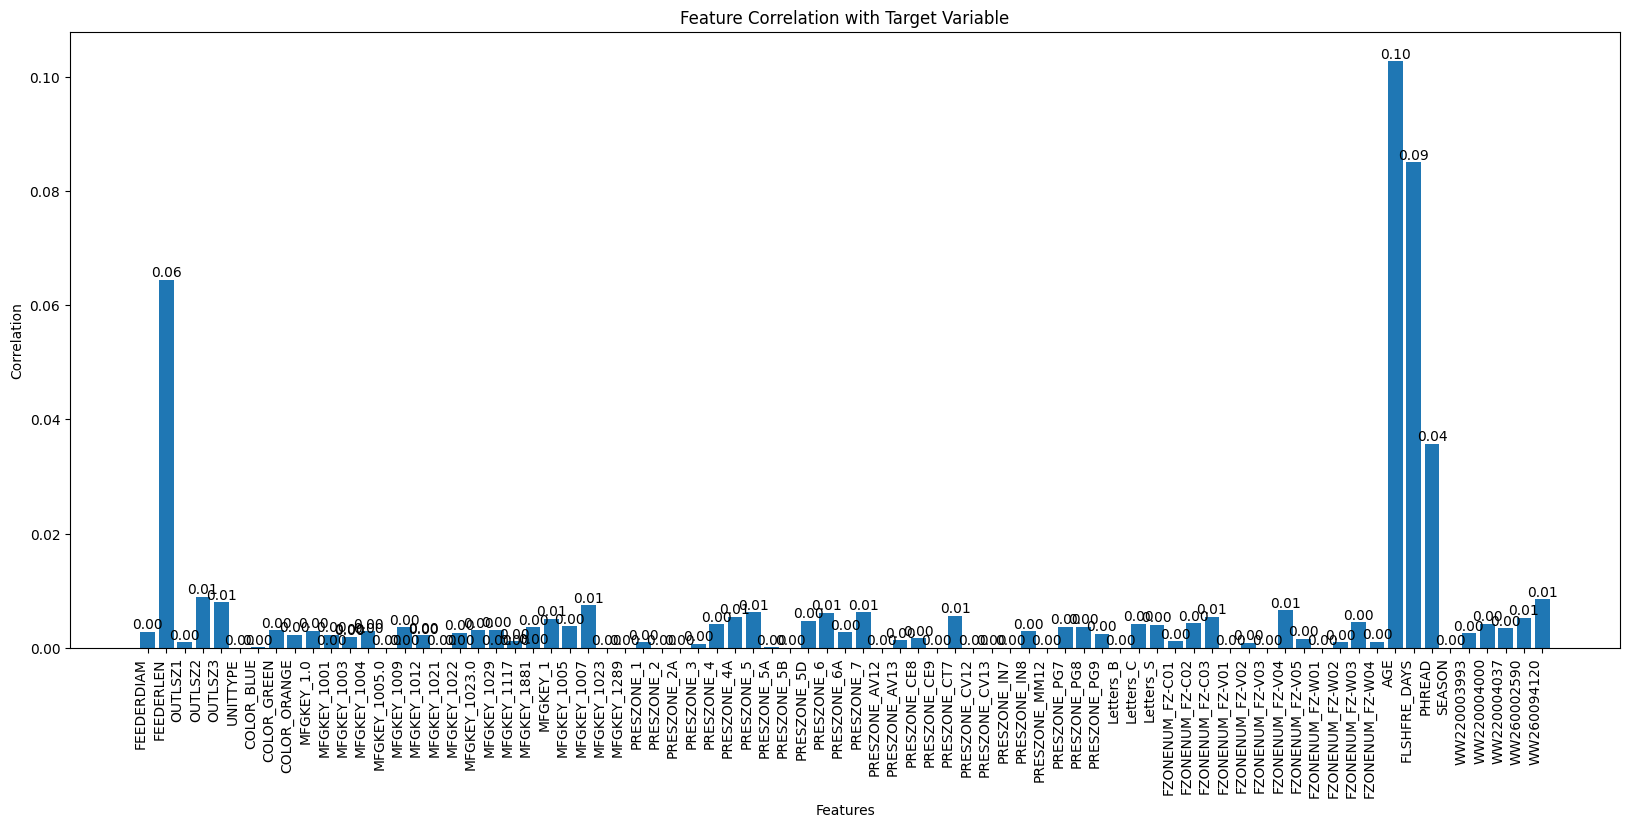

In [353]:
feature_names = x.columns.tolist()

# Create a bar plot
plt.figure(figsize=(20, 8))
bars = plt.bar(feature_names, mi_scores)

# Customize the plot
plt.title('Feature Correlation with Target Variable')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Correlation', fontsize=10)
plt.xticks(rotation=90, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Adjust layout and display the plot
#plt.tight_layout()
plt.show()

### Split the data into training and testing sets

In [ ]:
# The class to split the data into training and testing sets
from sklearn.model_selection import train_test_split

In [354]:
# Fraction of data to be used for testing; the rest is to be used for training
test_size = 0.3
random_state = 42

# Separating each of X and Y datasets into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

### Scaling the Data

In [ ]:
# Importing the class to use for scaling the data
from sklearn.preprocessing import MinMaxScaler

# Instantiating a MinMaxScaler object
scaler = MinMaxScaler()
# Fitting the scaler to the training features
scaler.fit(x_train)
# Scaling the training and testing features
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# Training the Model

### Model 1: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

### Hyperparameter Optimization

In [ ]:
import optuna

### Model 2: XGBoost Regression

### Hyperparameter Optimization

### Model 3: Support Vector Regression

In [ ]:
model

### Hyperparameter Optimization

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    svr_c = trial.suggest_float("svr_c", 1e-10, 1e10, log=True)
    svr_eps = trial.suggest_int("svr_eps", 1e-5, 1e5, log=True)

    model = SVR(kernel='rbf', C=svr_c, epsilon=svr_eps)

    score = cross_val_score(model, x, y, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
study.best_trial

### Model 4: Random Forest Regression

### Hyperparameter Optimization

# Result Comparison

## Comparing MSE (mean squared error)

## Consider adjusting the train-test split for better results

# Testing the Model